# 0.0. Imports

In [1]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import math
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat) / y))
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat)) 
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse}, index=[0])
def cross_validation(x_training, kfold, model_name, model, verbose=True):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKfold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_start_date)]

        # training and validation dataset
        xtraining = training.drop(['sales','date'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['sales','date'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model':model_name,
        'MAE cv': np.round(np.mean(mae_list),2).astype(str) + '+/-' + np.round(np.std(mae_list),2).astype(str),
        'MAPE cv': np.round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str),
        'RMSE cv': np.round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos Dados

## 1.1 Renomear Colunas

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Dimensão dos Dados

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Tipos dos dados

In [8]:
# Alterar o tipo de dados para data
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Valores Nulos/Faltantes

In [9]:
df1.isna().sum()[df1.isna().sum()>0].sort_values(ascending=False)

promo_interval                  508031
promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
dtype: int64

In [10]:
na = df1.isna().sum()[df1.isna().sum()>0].sort_values(ascending=False).index.tolist()
na

['promo_interval',
 'promo2_since_year',
 'promo2_since_week',
 'competition_open_since_year',
 'competition_open_since_month',
 'competition_distance']

## 1.5 Imputação dos dados faltantes

In [11]:
# Levantar hipóteses sobre as razões dos NAs


# 'competition_open_since_year',
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# 'competition_open_since_month',

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# 'competition_distance' --> Muito distante a ponto de não ser encarada como competição 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000 if math.isnan(x)else x)

# 'promo2_since_year',
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# 'promo2_since_week',
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# 'promo_interval',

month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul', 8:'Aug', 9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df1.fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6 Alterando os tipos de dados

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
# De float para int
df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
df1.competition_open_since_year = df1.competition_open_since_year.astype(int)
df1.promo2_since_week = df1.promo2_since_week.astype(int)
df1.promo2_since_year = df1.promo2_since_year.astype(int)

## 1.7 Estatística Descritiva

Tipos de métricas: 
* Tendência central: resumo dos dados em um único escalar 
    * Média e Mediana

* Dispensão: concentração ou dispersão em torno das medidas de tendência central 
    * Desvio Padrão
    * Skew: desformação/assimetria em relação à normal
    * Kurtosis: concentração dos dados em relação a determinado ponto
    * Mínimo, máximo e quartis

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# Dividir as variáveis entre categóricas e numéricas
num = df1.select_dtypes(include=['int64','int32','float'])
cat = df1.select_dtypes(include=['object'])

### 1.7.1 Variáveis numéricas

In [16]:
#Tendência Central - média e mediana
ct1 = pd.DataFrame(num.apply(np.mean)).T
ct2 = pd.DataFrame(num.apply(np.median)).T

# Dispersão - min, max, range, skew, curtosis
d1 = pd.DataFrame(num.apply(np.std)).T
d2 = pd.DataFrame(num.apply(min)).T
d3 = pd.DataFrame(num.apply(max)).T
d4 = pd.DataFrame(num.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

# Concatenar os dataframes
m = pd.concat([d2,d3,d4,ct1,ct2,d1, d5,d6]).T.reset_index()
columns = ['attributes','min','max','range', 'mean','median', 'std','skew','kurtosis']
m.head()

,index,0,0,0,0,0,0,0,0
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723


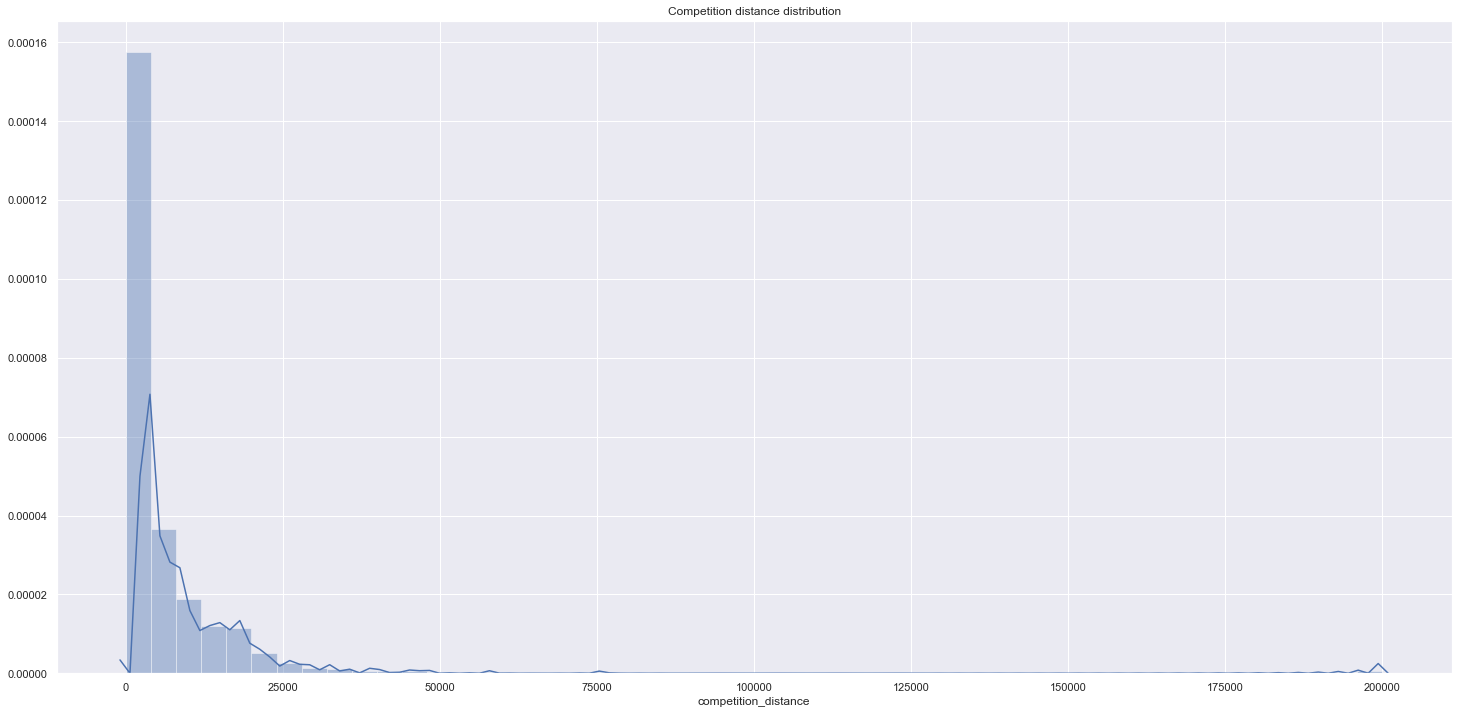

In [17]:
# Exemplo: há uma concentração muito grande de competidores nas proximidades das lojas
sns.distplot(df1['competition_distance']).set_title('Competition distance distribution');

### 1.7.2 Variáveis categóricas

In [18]:
cat.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

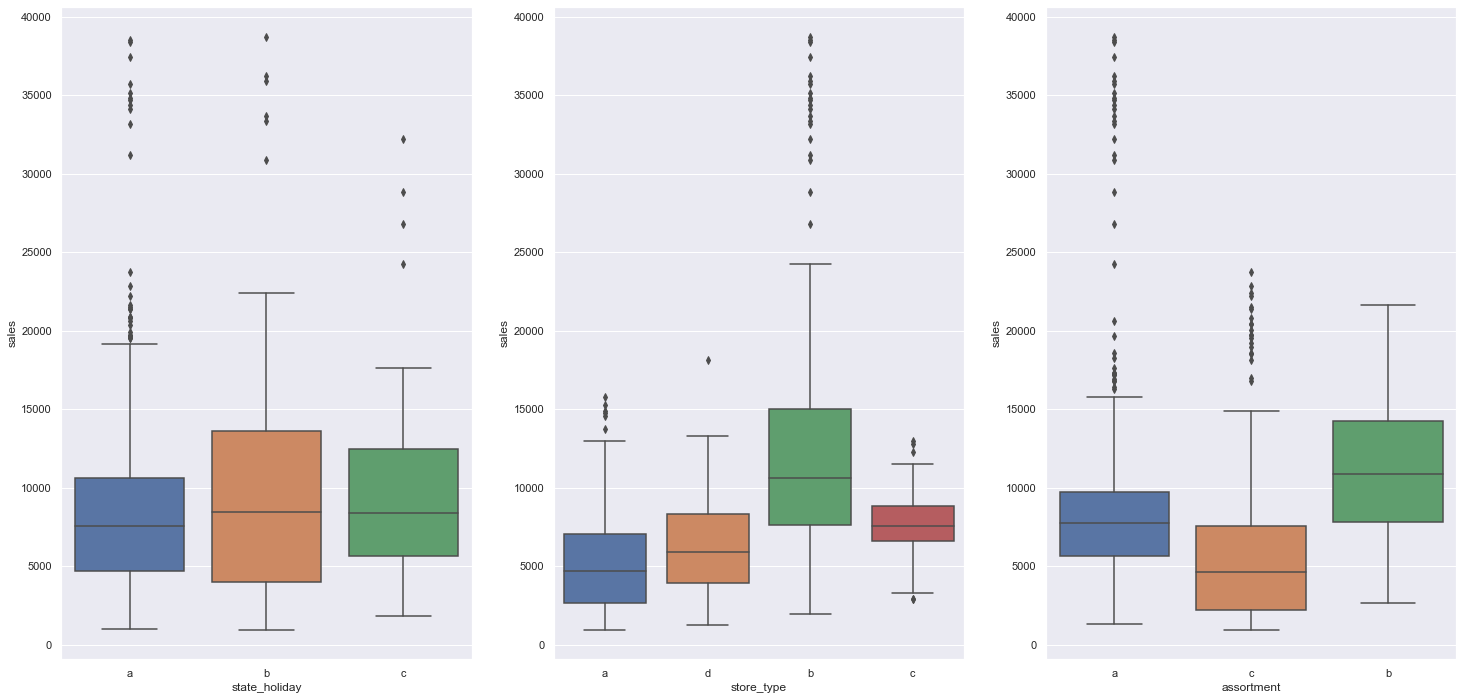

In [19]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux);

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux);

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2.0 Feature Engeneering

In [20]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

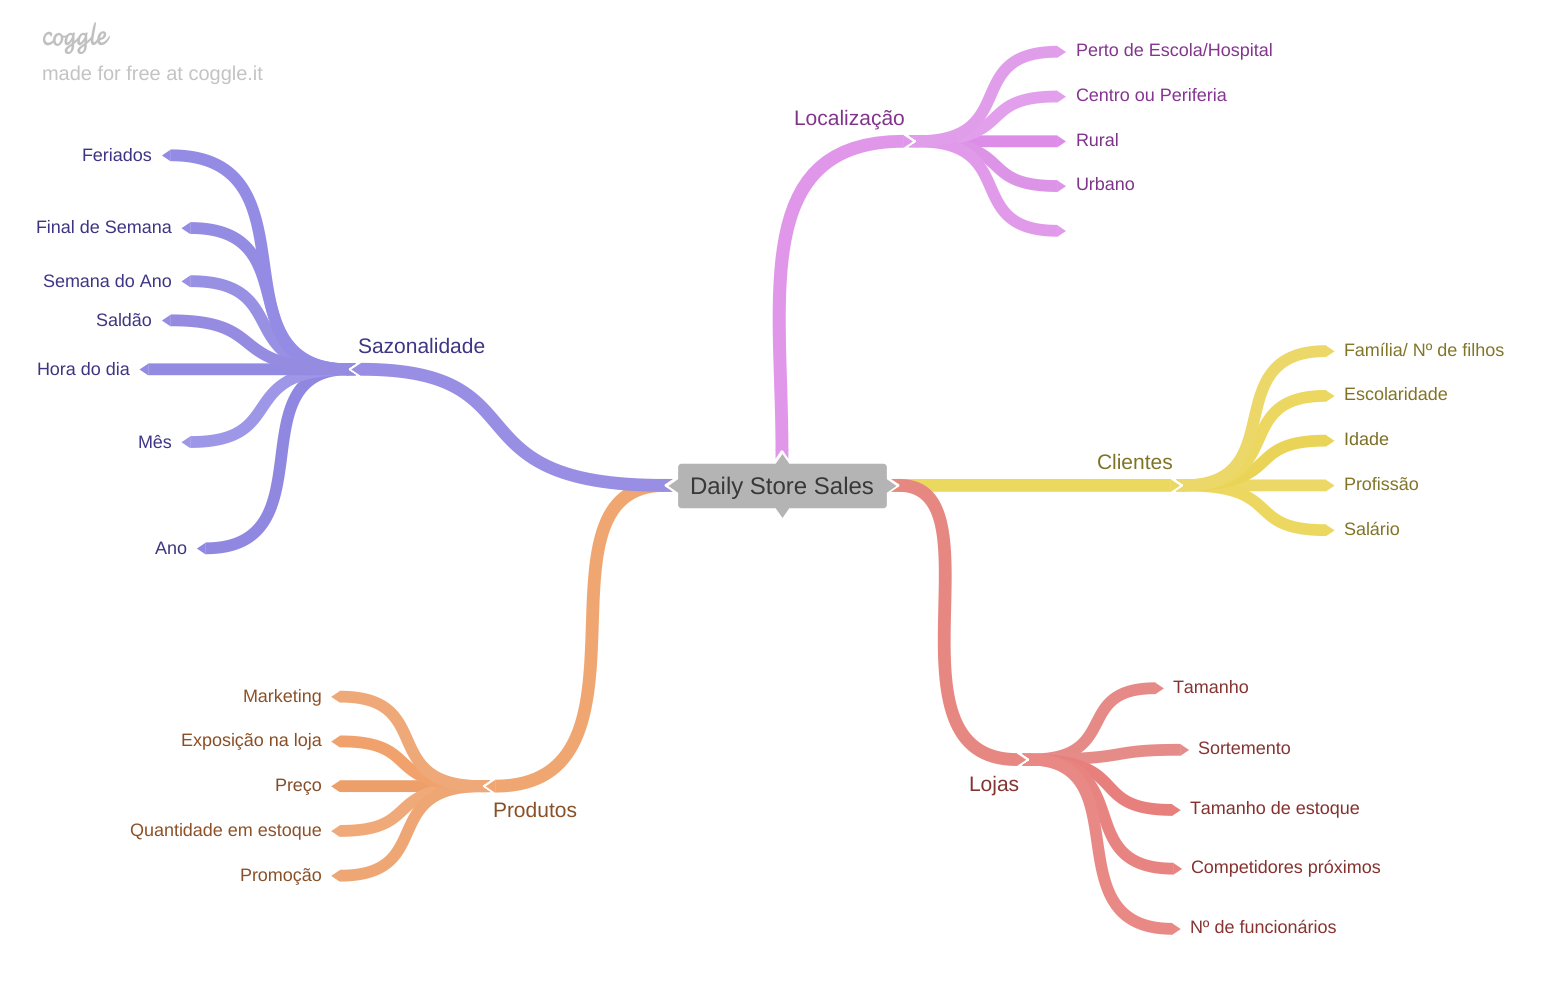

In [21]:
Image('Mind_map.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses - Loja

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais

### 2.2.2. Hipoteses - Produto

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3. Hipoteses - Tempo¶


1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.


###  2.3. Lista Final de Hipóteses (baseada na disponibilidade de dados)

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Feature Engeneering

In [22]:
df2 = df2.copy()

In [23]:
# Year
df2['year'] =df2['date'].dt.year

# Month
df2['month'] =df2['date'].dt.month

# Day 
df2['day'] =df2['date'].dt.day

# Week of year
df2['week_of_year'] =df2['date'].dt.weekofyear

# Year week
df2['year_week'] =df2['date'].dt.strftime('%Y-%W')


# competition since
years = df1.loc[df1['competition_open_since_year']<1677, 'competition_open_since_year'].unique().tolist()
years_dic = {7:2007, 6:2006, 5:2005, 4:2004, 3:2003, 2:2002, 1:2001, 12:2012, 11:2011, 10:2010, 9:2009, 8:2008}
df2['competition_open_since_year'].replace(years_dic, inplace=True)
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].replace({'a':'basic', "b": 'extra', 'c':'extended'})

# state holiday
df2['state_holiday'] = df2['state_holiday'].replace({'a':'public holiday', 'b': 'Easter holiday', 'c':'Christmas', '0':'regular_day'})

# 3.0 Filtragem de variáveis

In [24]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [25]:
# Filtrar open (apenas dias de loja aberta) e sales (apenas vendas acima de 0)
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2 Seleção das colunas

In [26]:
df3.drop(['customers','open', 'promo_interval', 'month_map'],axis=1, inplace=True)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados

Vale pontuar que os filtros e as máscaras aplicados ao dataset nessa seção servem apenas para a observação do comportamento dos dados e não são aplicados no momento do treinamento do modelo. Eles servem apenas como uma lupa para analisarmos quais os comportamentos dos dados

In [28]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável resposta

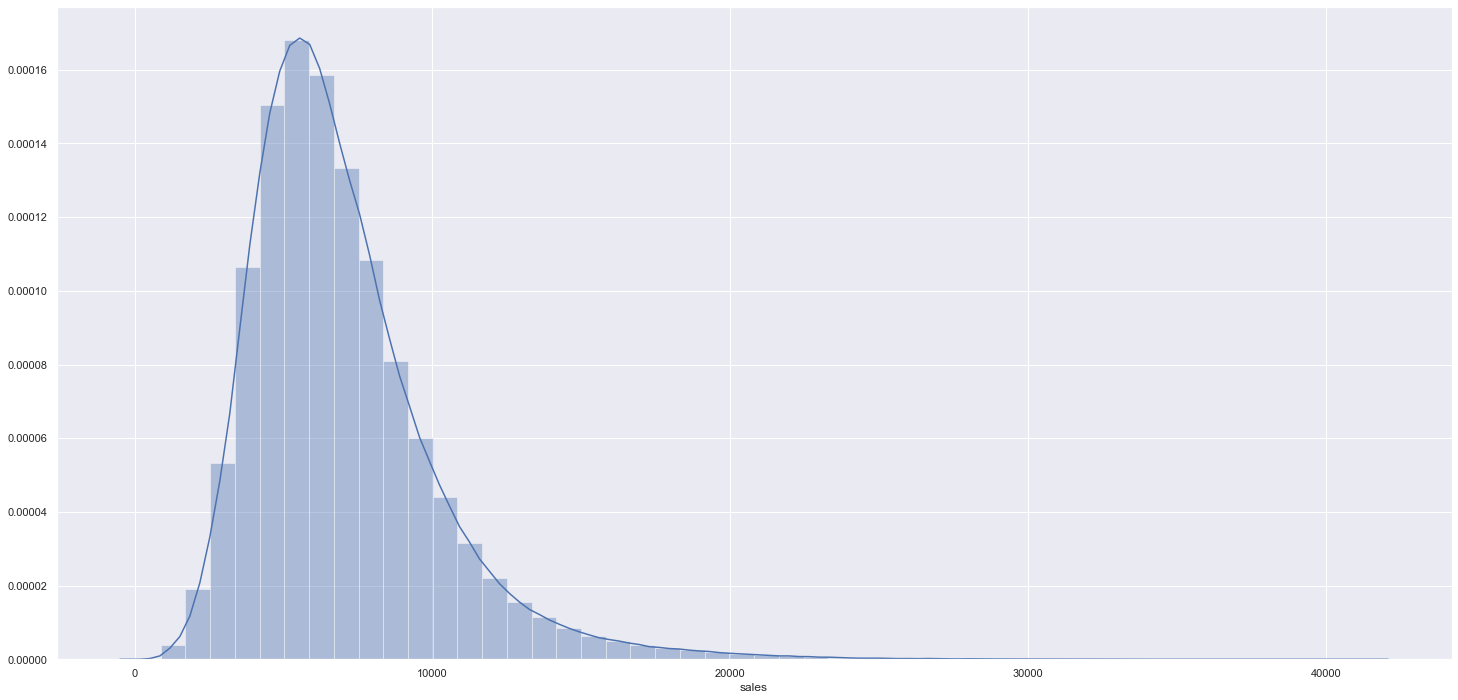

In [29]:
sns.distplot(df4.sales); # Assimetria positiva

### 4.1.2 Variáveis numéricas

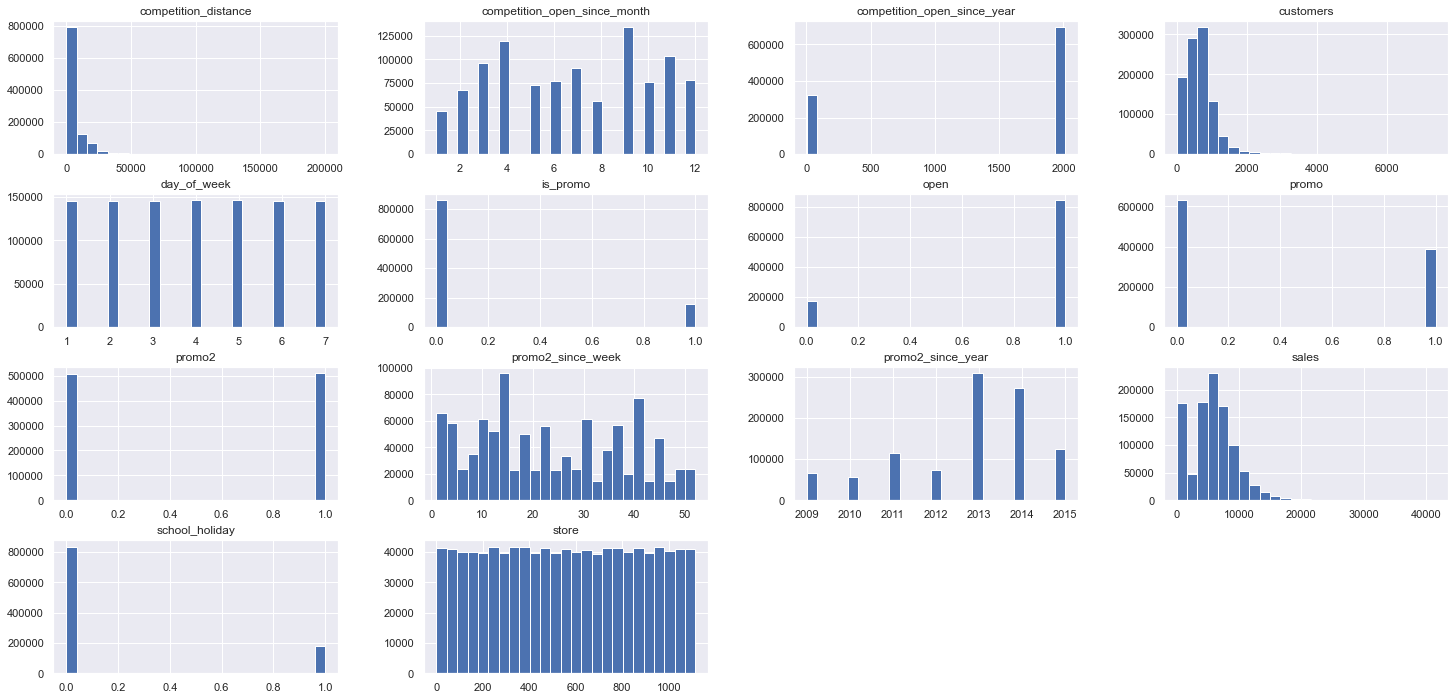

In [30]:
num.hist(bins=25);

In [31]:
# Formular afirmações sobre o comportamento das variáveis acima

### 4.1.3 Variáveis categóricas

In [32]:
cat.columns
# Variáveis de destaque:
# state_holiday, store_type, assortment

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

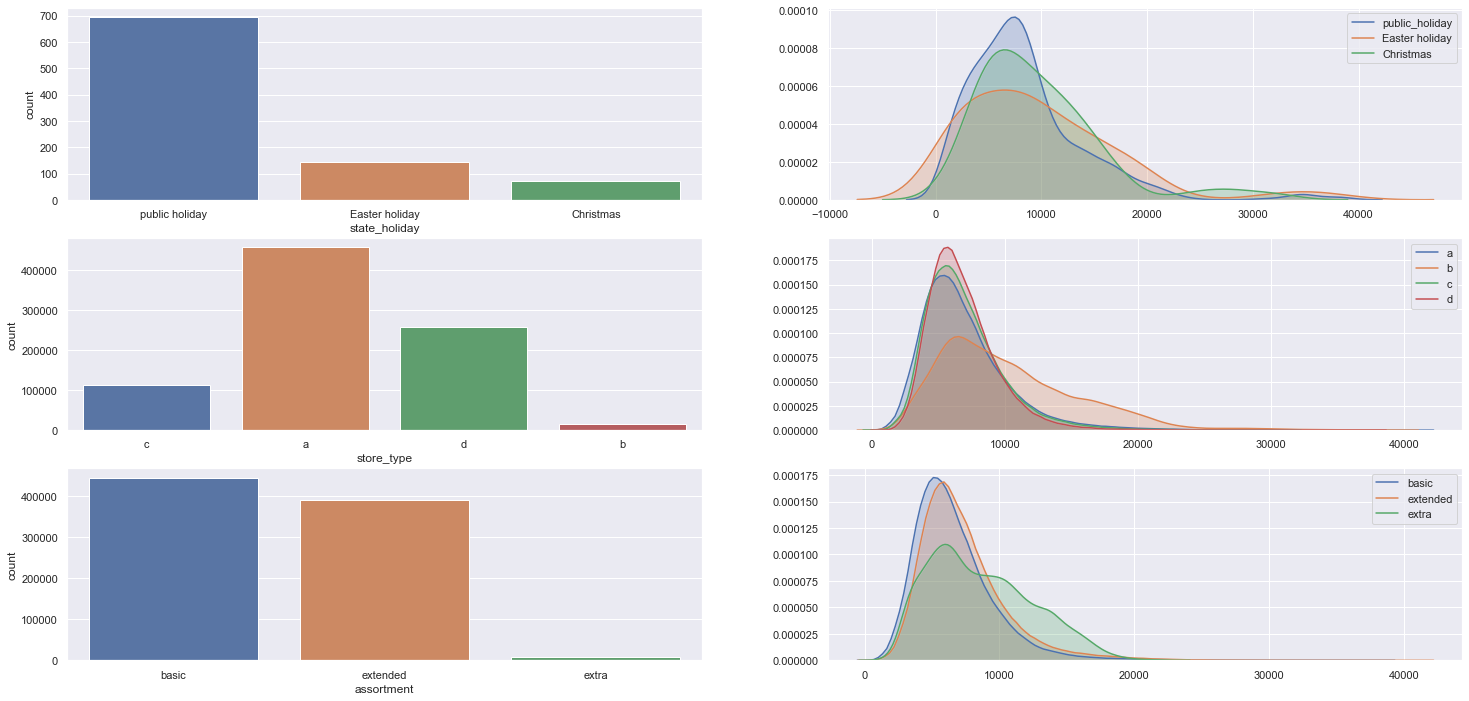

In [33]:
# Como há muito mais dias reguladores do que os demais, vamos retirar o 'regular_day' para ter uma melhor noção
# dessa demais categorias

# state_holiday 
plt.subplot(3,2,1)
not_regular = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(not_regular['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']== 'public holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday']== 'Easter holiday']['sales'], label='Easter holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday']== 'Christmas']['sales'], label='Christmas', shade=True);

# store_type
plt.subplot(3,2,3)

sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']== 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type']== 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type']== 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type']== 'd']['sales'], label='d', shade=True);

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']== 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment']== 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment']== 'extra']['sales'], label='extra', shade=True);


## 4.2 Análise Bivariada

### H1 - Lojas com maior sortimentos deveriam vender mais.
**Conclusão**: A hipótese é **falsa** porque as lojas com maiores sortimentos vendem MENOS.
No entanto, é interessamte manter essa variável para que o modelo possa retirar informações sobre a diferenciação entre as categorias basic/extended e extra, uma vez que essa última possui uma sacionalidade peculiar. 

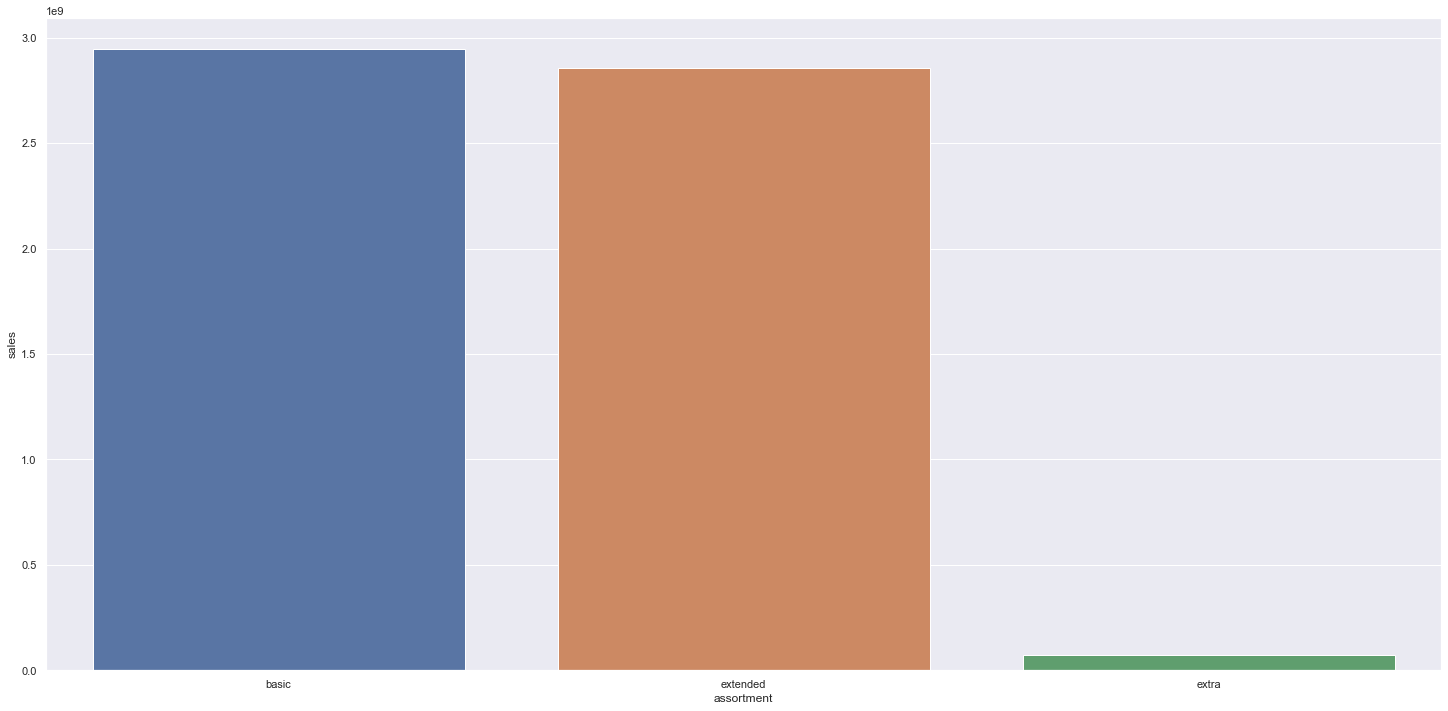

In [34]:
# Podemos conferir que a hipótese é frágil diante do gráfico abaixo que aponta que o maior sortimento 
# da cartela de produto não é acompanhada de maiores soma das vendas
# No entando, essa é a avaliação geral, devemos conferir se houve alguma evolução ao longo do tempo.
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales', data=aux1);

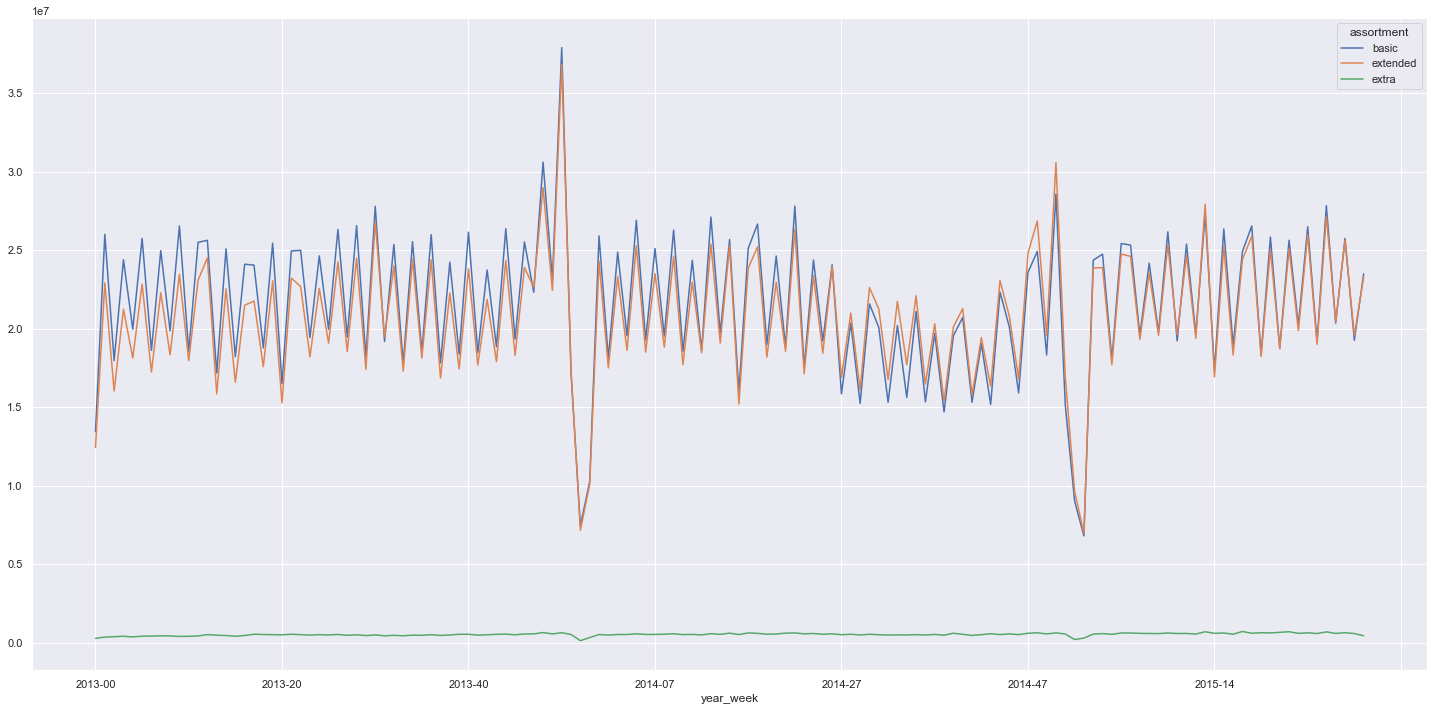

In [35]:
# Adicionando a temporalidade year_week
aux2 = df4[['year_week','assortment','sales']].groupby(['assortment','year_week']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values = 'sales').plot();

# O desempenho dos sortimentos basic e extend acompanham um ao outro, são bem similares. 

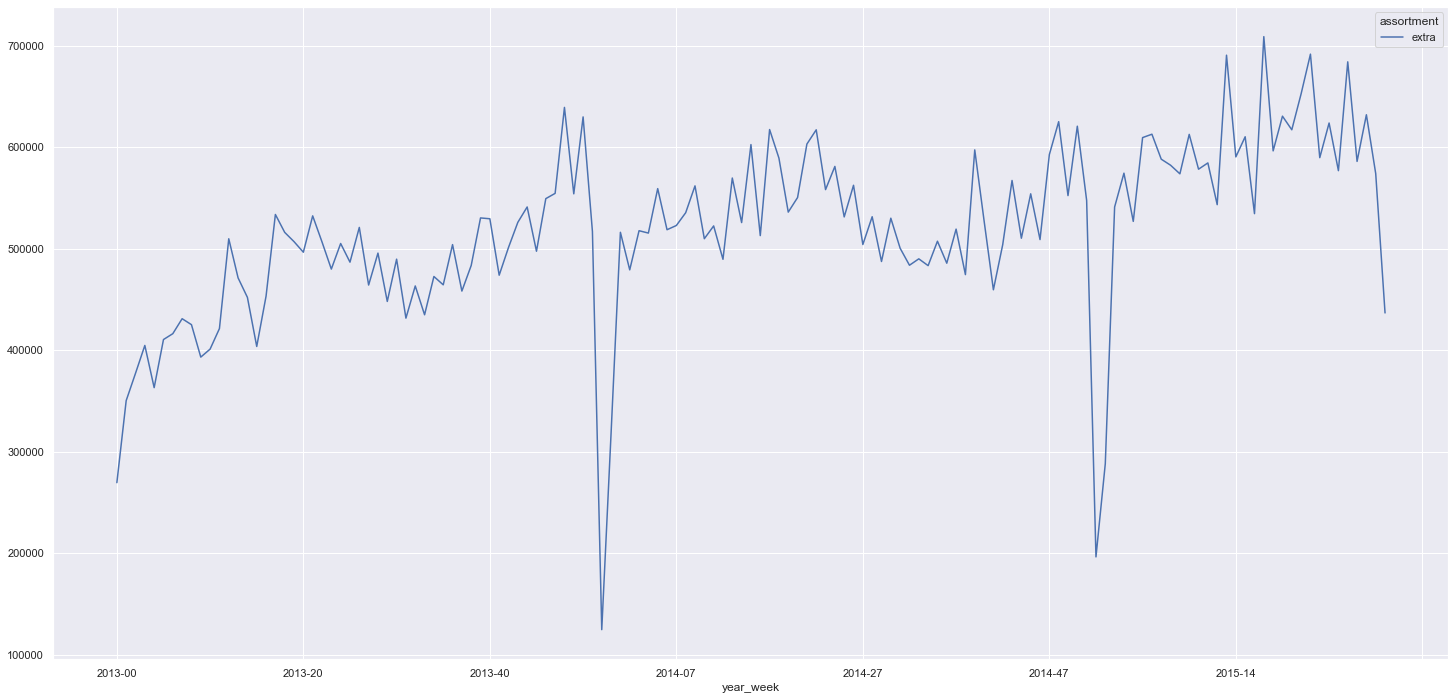

In [36]:
# Vamos conferir o comportamento das vendas de Extra para conferir se ele realmente é linear
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values = 'sales').plot();

###  H2 - Lojas com competidores mais próximos deveriam vender menos.
**Conclusão:** a hipótese é falsa porque lojas com competidores mais próximos vendem MAIS.

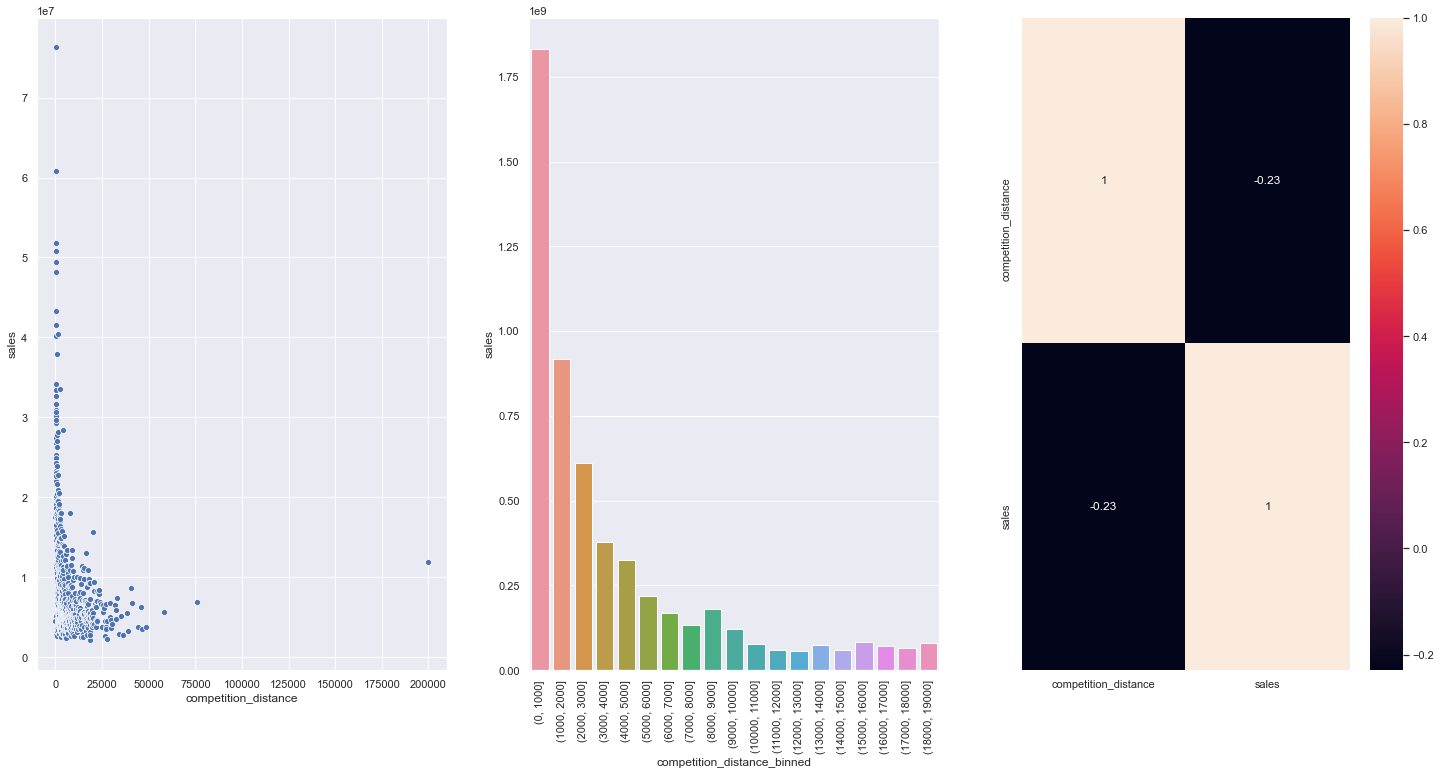

In [37]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3 - Lojas com competidores à mais tempo deveriam vendem mais
**Conclusão:** a hipótese é falda. Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS.


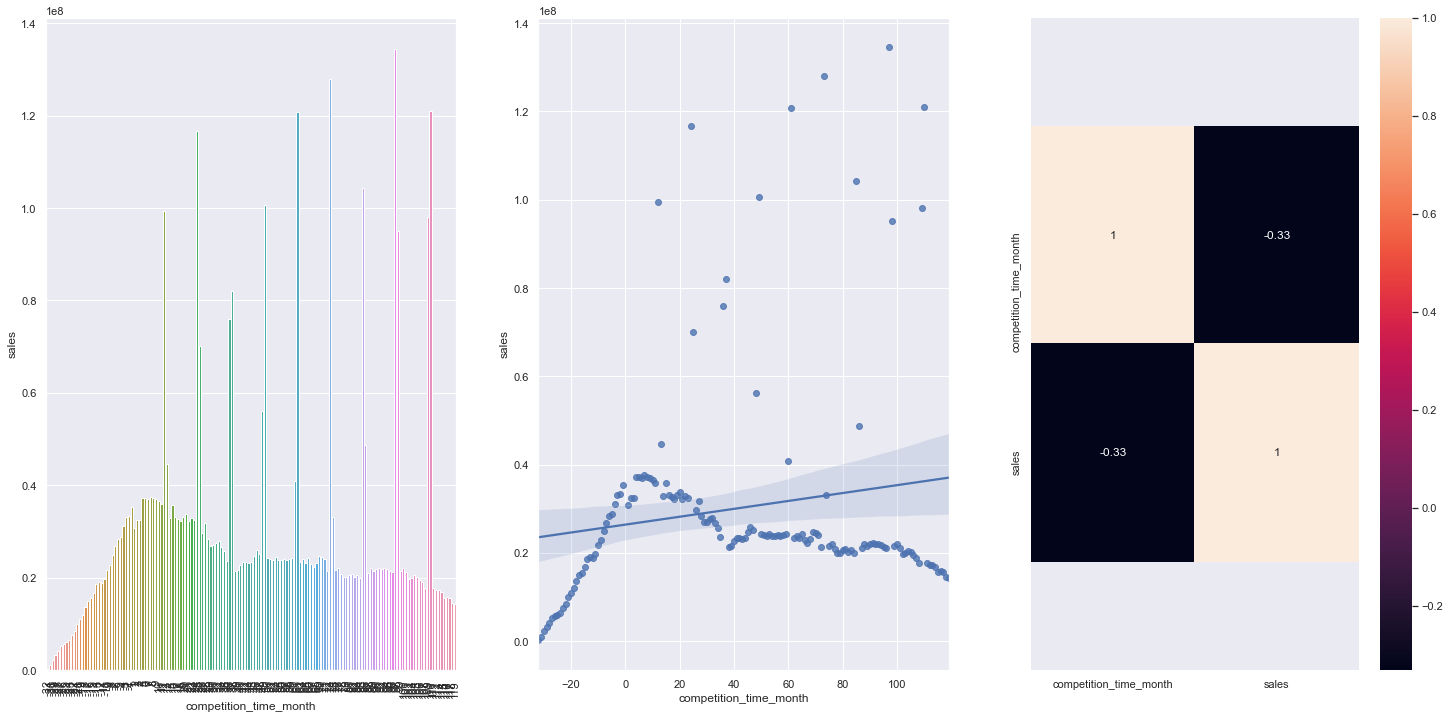

In [38]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);



### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**Conclusão:** A hipótese é falsa. Lojas com promoções ativa por mais tempo vendem menos a partir de determinado período.

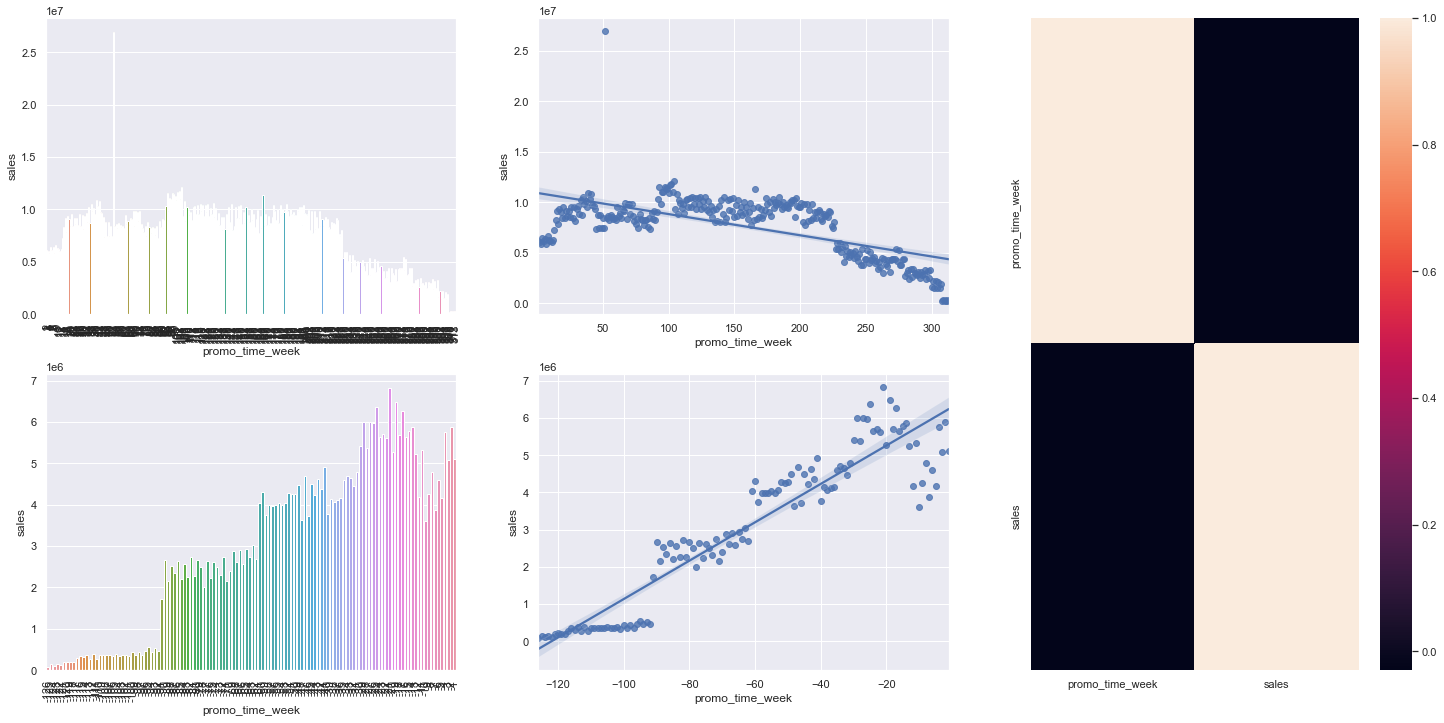

In [39]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week', y='sales',data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] >0] # promo extendida
sns.barplot(x='promo_time_week', y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2 );

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3 );

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'));

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.</s> --> Já é representada pela H4, podemos revisá-la no segundo ciclo do CRISP

### H6. Lojas com mais promoções consecutivas deveriam vender mais
**Conclusão:**   A hipótese é falsa porque lojas com mais promoções consecutivas vendem menos.

Além disso, devido ao comportamento muito similar de `promo` e `promo2`, talvez uma delas não seja interessante para o modelo, afim de evitar colinearidade, hipótese a ser submetido a um algoritmo de seleção.

In [40]:
df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


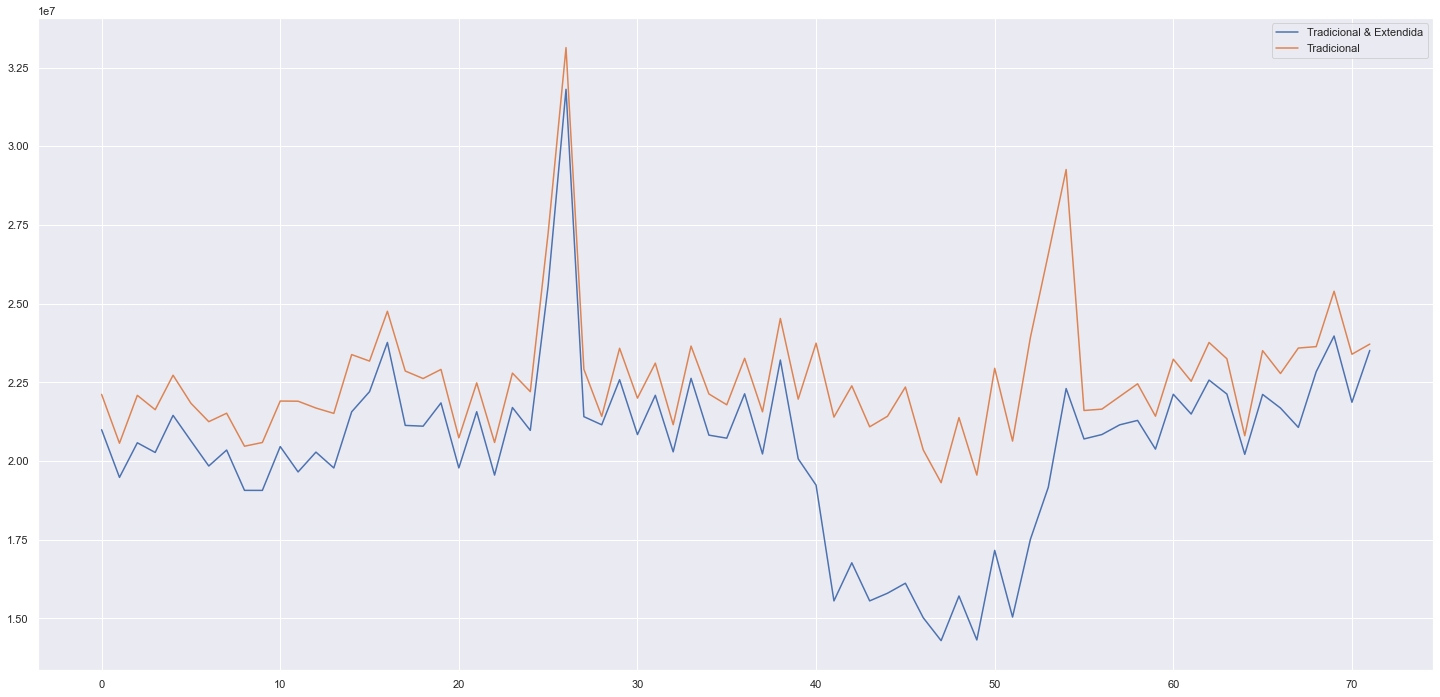

In [41]:
aux1 = df4[(df1['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df1['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);
ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Conclusão:** A hipótese é falsa porque lojas abertas durante o feriado de Natal vendem menos tanto em relação aos dias regulares quanto em relação aos demais feriados.


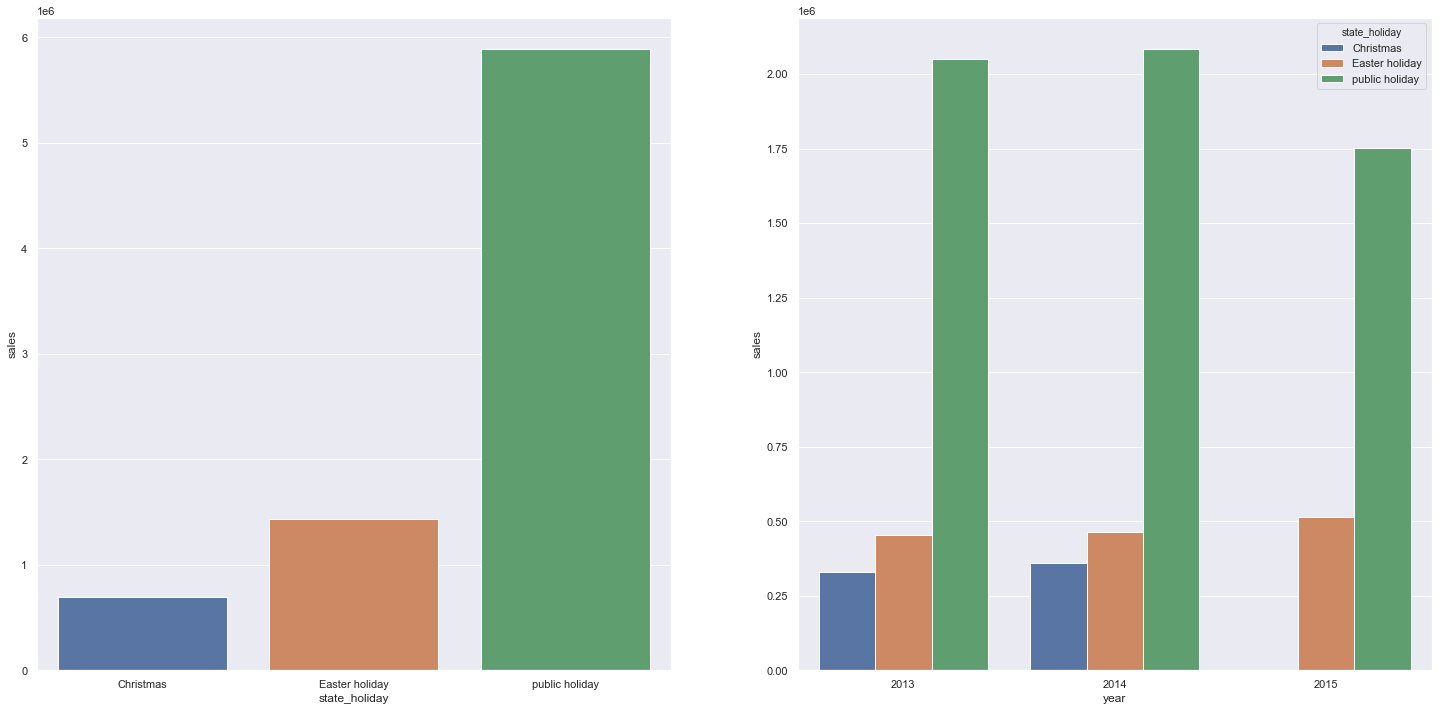

In [42]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] !='regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2);


###  H9. Lojas deveriam vender mais ao longo dos anos.
**Conclusão:** A hipótese é falsa porque as lojas vendem menos ao longo dos anos.

É importante frisar que as análise envolvendo anos devem priorar períodos já concluídos de tempo, caso contrário resultados enviesados podem ser retirados como é o caso da forte correlação negativa entre anos e soma de vendas abaixo

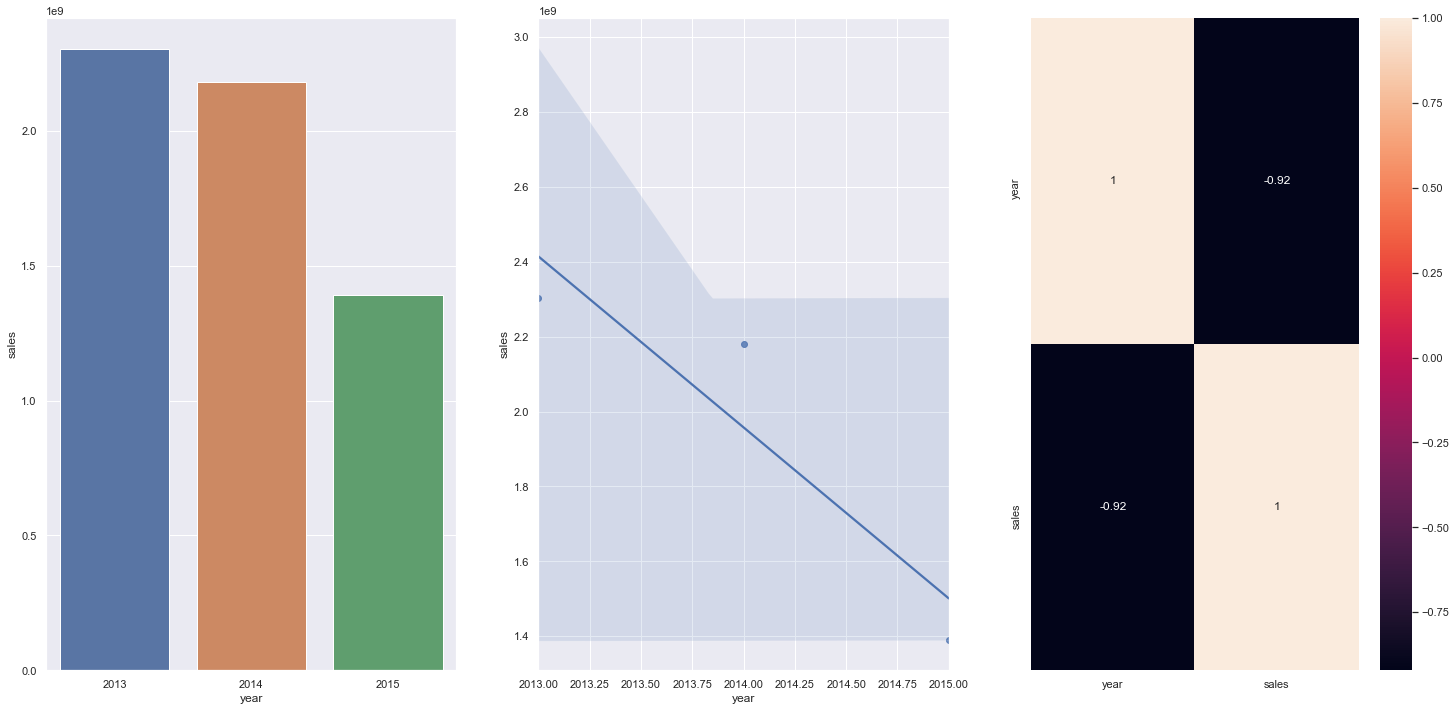

In [43]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year',y='sales', data= aux1);
plt.subplot(1,3,2)
sns.regplot(x='year',y='sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(data=aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais no segundo semestre do ano.
**Conclusão:** a hipótese é falsa porque as lojas vendem menos a partir do segundo semestre.

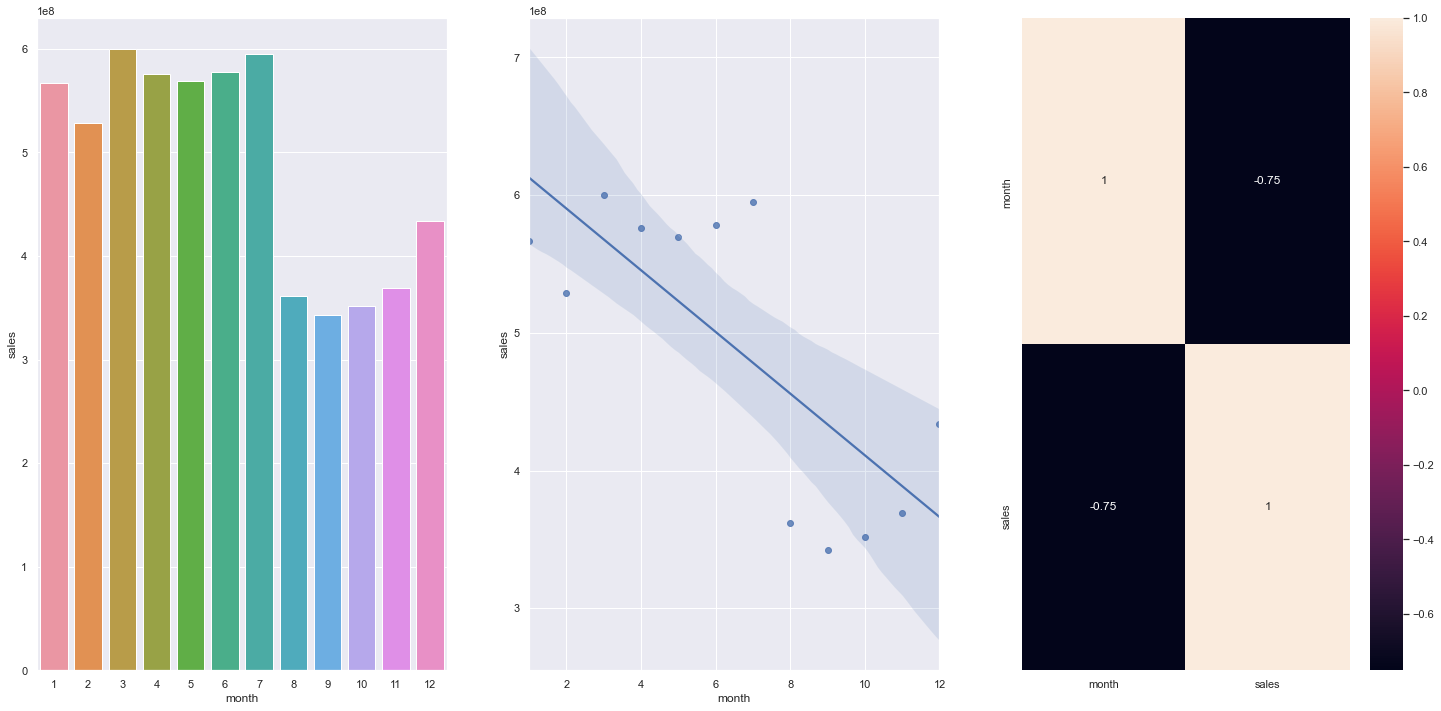

In [44]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month',y='sales', data= aux1);
plt.subplot(1,3,2)
sns.regplot(x='month',y='sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(data=aux1.corr(method='pearson'), annot=True);

###  H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**Conclusão:** A hipótese está correta porque as lojas vendem mais após o décimo dia dos mês.

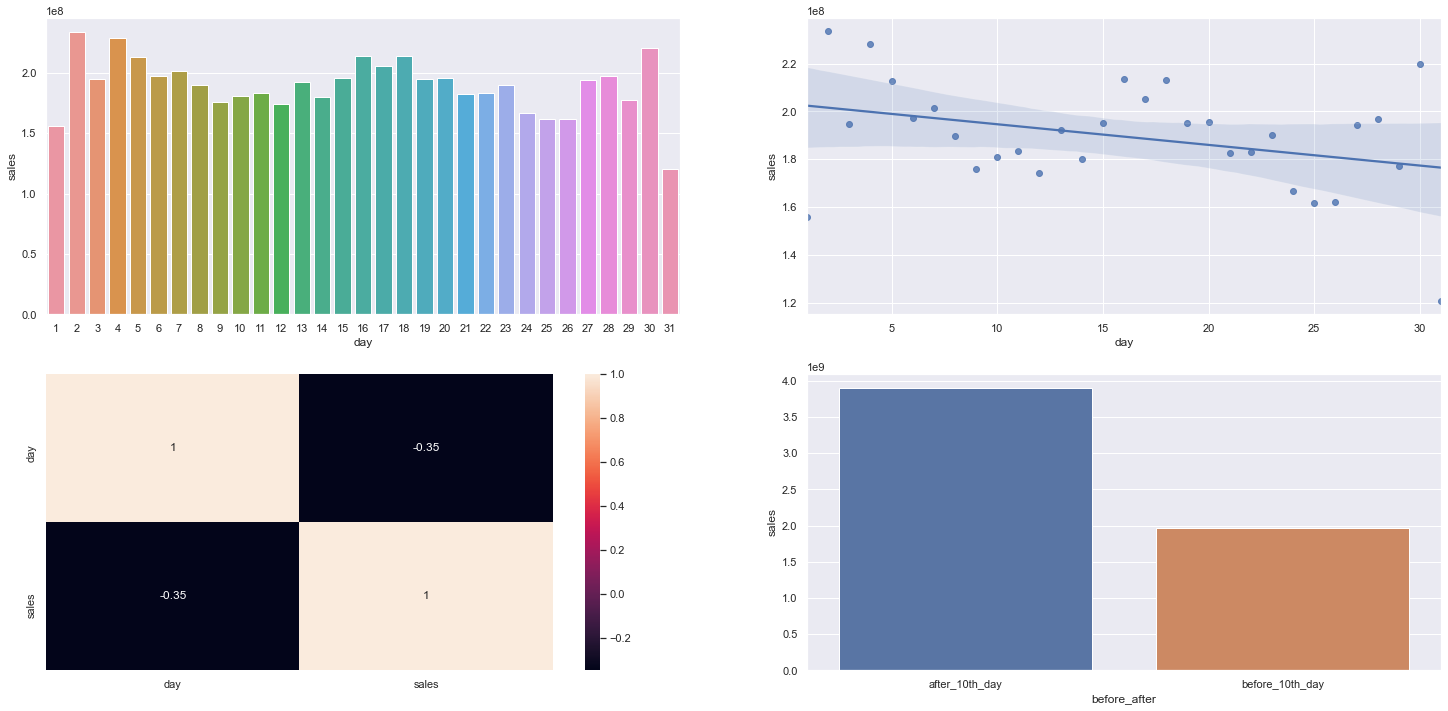

In [45]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales', data= aux1);
plt.subplot(2,2,2)
sns.regplot(x='day',y='sales', data= aux1);
plt.subplot(2,2,3)
sns.heatmap(data=aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x:'before_10th_day' if x <= 10 else 'after_10th_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales', data= aux2);


###  H12. Lojas deveriam vender menos aos finais de semana.
**Conclusão:** A hipótese é verdadeira porque as lojas vendem menos nos fins de semana

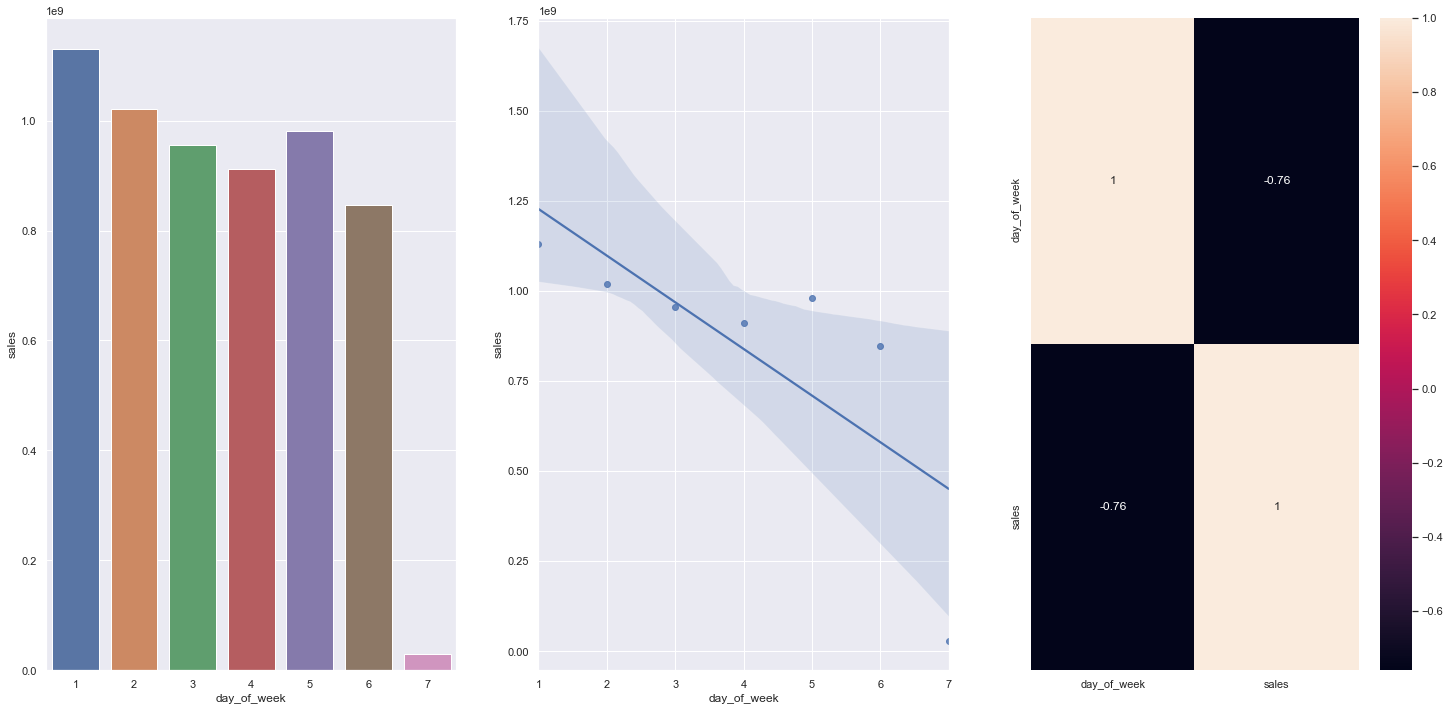

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales', data= aux1);
plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(data=aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriados escolares.
**Conclusão:** A hipótese é verdadeira porque lojas vendem menos durante os feriadso escolares, com exceção dos meses de Julho e Agosto.

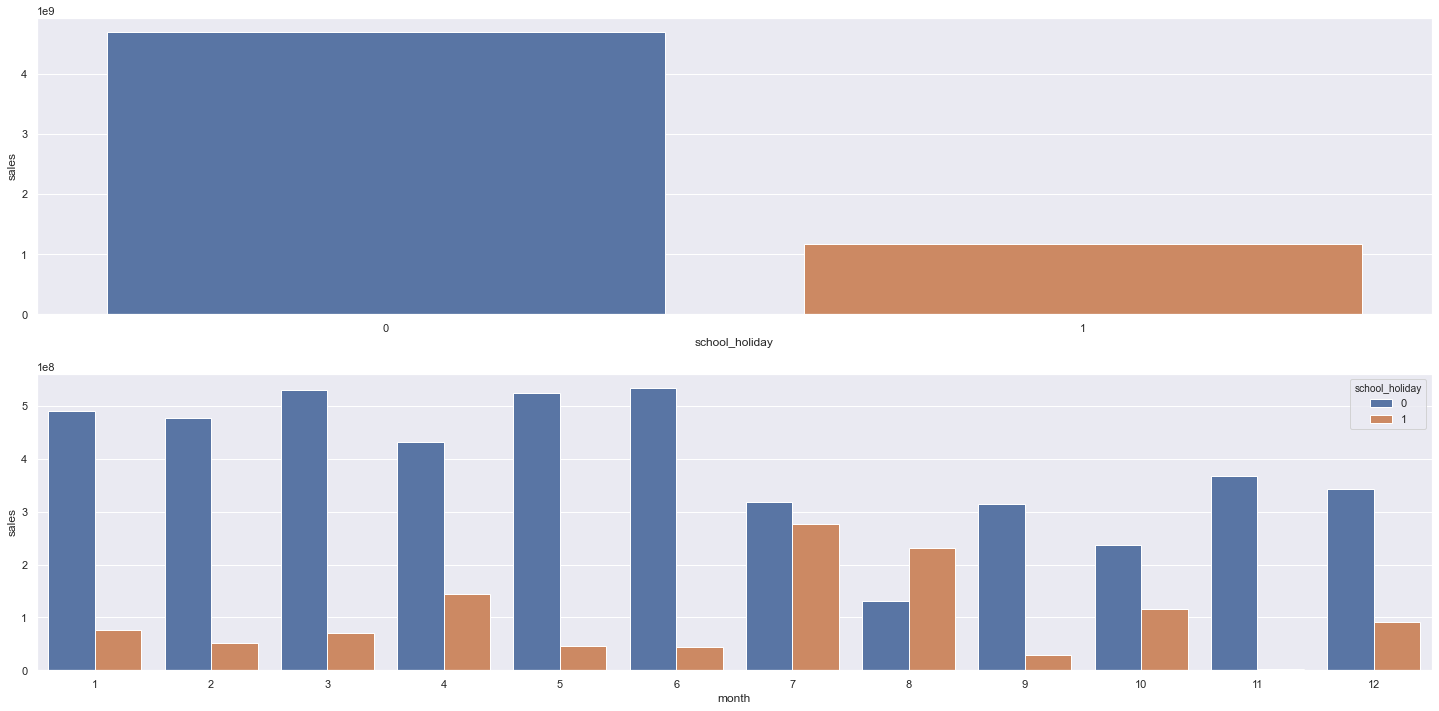

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales', data=aux1);
plt.subplot(2,1,2)
aux2= df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday', data=aux2);

Duas perspectivas sobre as hipóteses na análise exploratória de dados:

1) sobre a hipótese ter sido validada ou rejeitada e se podem gerar insights

2) as variáveis da análise bivariadas podem ser interessantes para o modelo?


O objetivo é gerar um reflexão sobre a relevânci das variáveis para o fenômeno e para o modelo

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

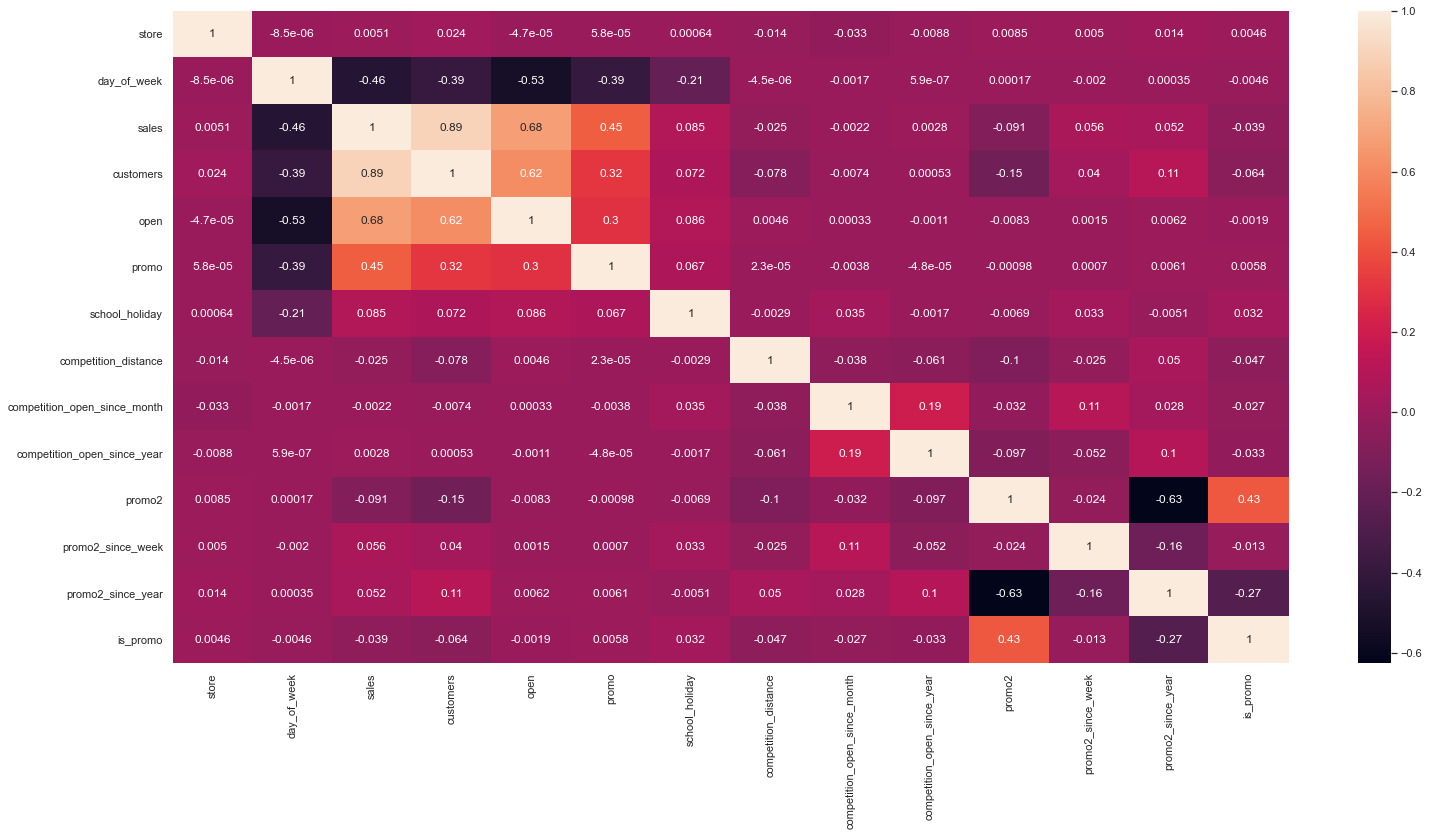

In [48]:
corr = num.corr(method='pearson')
sns.heatmap(corr,annot=True);

### 4.3.2 Variáveis Categóricas

In [49]:
c = df4.select_dtypes(include='object')

In [50]:
# # only categorical data
# a = df4.select_dtypes( include='object' )

# # Calculate cramer V
# a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
# a2 = cramer_v( a['state_holiday'], a['store_type'] )
# a3 = cramer_v( a['state_holiday'], a['assortment'] )

# a4 = cramer_v( a['store_type'], a['state_holiday'] )
# a5 = cramer_v( a['store_type'], a['store_type'] )
# a6 = cramer_v( a['store_type'], a['assortment'] )

# a7 = cramer_v( a['assortment'], a['state_holiday'] )
# a8 = cramer_v( a['assortment'], a['store_type'] )
# a9 = cramer_v( a['assortment'], a['assortment'] )

# # Final dataset
# d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
#                'store_type': [a4, a5, a6],
#                'assortment': [a7, a8, a9]  })
# # d = d.set_index( d.columns )

# # sns.heatmap( d, annot=True )

# 5.0 Preparação dos Dados

Razões para a preparação dos dados:
1. Trabsformação de variáveis categóricas em variáveis numéricas
2. Colocar as variáveis numéricas numa mesma escala

In [51]:
df5 = df4.copy()
# Variáveis numéricas
n = df5.select_dtypes(include=['int64','float64'])

## 5.1. Normalização

## 5.2 Rescaling

**Robust Scaler**

In [52]:
rs = RobustScaler()

In [53]:
# Competition distance -> Muitos outliers adicionados anteriormente pra preencher os NAs
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# Competition time month -> Muitos outliers
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

**Mix Max Scaler**

In [54]:
mms = MinMaxScaler()

In [55]:
# Promo time weak
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# Year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação dos dados

### 5.3.1 Encoding

In [56]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Transformação da variável resposta

In [57]:
df5['sales'] = np.log1p(df5['sales'])

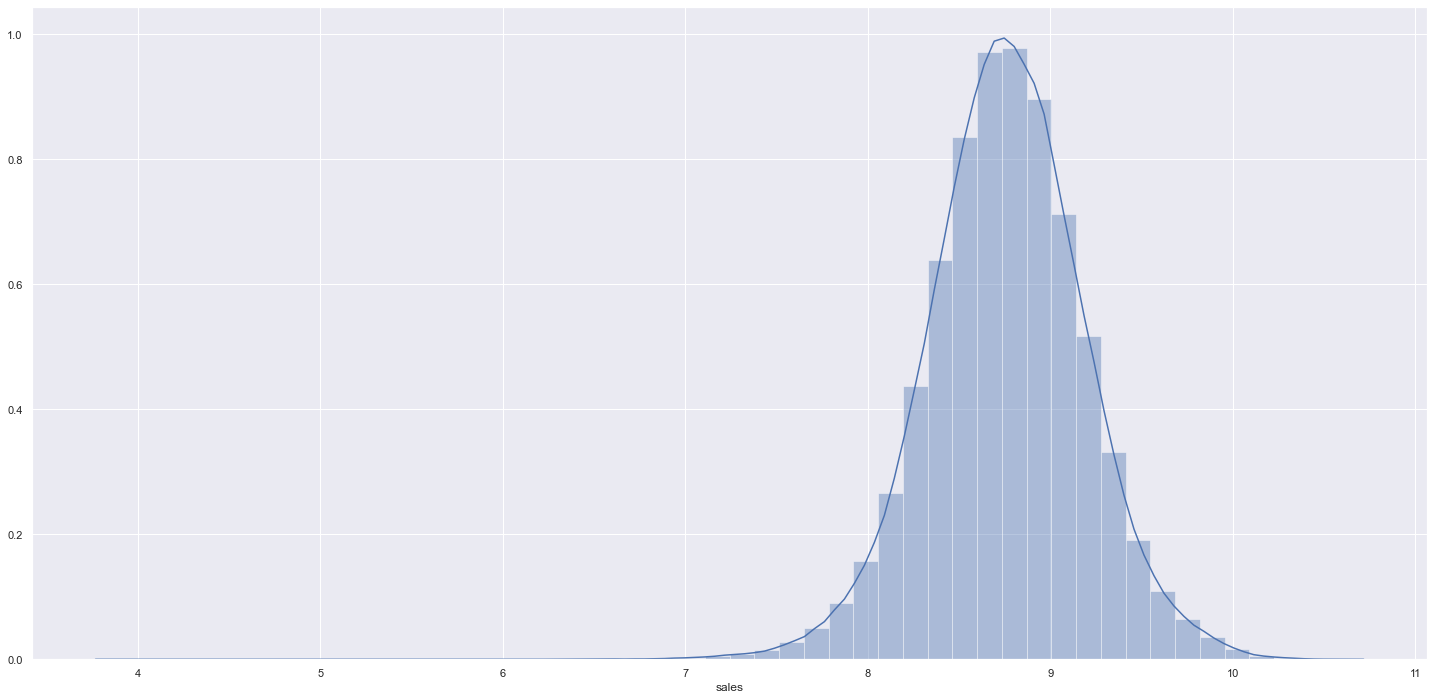

In [58]:
sns.distplot(df5['sales']);

### 5.3.3 Transformação de Natureza dos dados
    
    Transformação de natureza cíclica

In [59]:
# Day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2* np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2* np.pi/7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2* np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2* np.pi/12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2* np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2* np.pi/30)))
# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2* np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2* np.pi/52)))

# 6.0 Seleção de Variáveis

In [60]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [61]:
cols_drop = ['week_of_year', 'day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

Como se trata de uma análise de cunho temporal, não podemos fazer a divisão do dataframe de forma aleatória tendo em vista que isso misturaria dados do passado e do futuro. 

Uma vez que o objetivo é prever as próximas 6 semanas de vendas, a ideia aqui é separar as últimas 6 semanas para serem os dados de teste enquanto os dados desde o início até esse ponto são designados como treino.

In [62]:
# 6 semanas antes da última data (ponto limite entre treino e teste)
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [95]:
# Training dateset
X_train = df6[df6['date']<'2015-06-19']
y_train = X_train['sales']

# Test dateset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('Test Min Date: {}'.format(x_test['date'].min()))
print('Test Max Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [64]:
# # training and test dataset for Boruta
# x_train_n = x_train.drop(['date','sales'],axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define boruta
# # boruta = BorutaPy(rf, n_estimators='auto',verbose=2, random_state=42).fit(x_train_n,y_train_n.ravel())

### 6.2.1 Best features from Boruta

In [65]:
# cols_selected = boruta.support_.tolist()

# #best featuress
# x_train_fs = x_train.drop(['date','sales'], axis=1)
# cols_selected_boruta = x_train.iloc[:,cols_selected
# x_train_fs. columns, cols_selected_boruta                                   

## 6.3 Manual Feature Selection

In [66]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [96]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [68]:
# dataset for timeseries
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

Apesar da simplicidade, o modelo de média serve como base de comparação para os demais modelos.

In [69]:
# Funções para métricas de Performance

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat) / y))
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat)) 
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse}, index=[0])

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# perfomance
baseline_result = ml_error('Average_Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average_Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

É importante começar com um modelo linear para testamos sua acurácia, seguindo preceito de Occam's Razor que dá primazia à modelo simples. Caso o modelo linear não sei apto para a modelgame do fenêmono, passa-se a testar outras opções.

In [71]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.616829,0.292633,2672.508806


Com base no RMSE, podemos concluir que o modelo de regressão linear é inferior ao modelo de média. Além disso, devido ao erro elevados, podemos inferir que nossos dados são complexos e não apresentam um comportamento linear, o que nos força a recorrer a modelos não-lineares.

## 7.2.1 Linear Regression Model - Cross Validation

In [72]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model,MAE cv,MAPE cv,RMSE cv
0,Linear Regression,1858.85+/-584.62,0.29+/-0.05,2696.95+/-931.07


## 7.3 Linear Regression Regularized Model - Lasso

In [73]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1892.200337,0.289065,2745.442033


## 7.3.1 Lasso - Cross Validation

In [74]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model,MAE cv,MAPE cv,RMSE cv
0,Lasso,1864.83+/-616.8,0.28+/-0.04,2725.29+/-998.8


## 7.4. Random Forest Regressor¶

In [75]:
# # model
# rf = RandomForestRegressor(n_estimators =100,
#                           n_jobs=-1,
#                           random_state=42).fit(x_train, y_train)

# # prediction
# yhat_rf = rf.predict(x_test)

# # performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

## 7.4. Random Forest Regressor - Cross Validation

In [76]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
# rf_result_cv

## 7.5. XGBoost Regressor

In [77]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[08:58:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6684.076383,0.949586,7331.191587


### 7.5.1 XGBoost Regressor - Cross Validation

In [78]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=False)
xgb_result_cv

[09:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only u

,Model,MAE cv,MAPE cv,RMSE cv
0,XGBoost,6124.61+/-840.65,0.95+/-0.0,6689.09+/-1034.78


## 7.6 Models' Performances Comparation

In [79]:
modelling_results = pd.concat([baseline_result, lr_result, lrr_result,xgb_result]) # rf_result - incluir quaando
# for adicionar a Random Forest
modelling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average_Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.616829,0.292633,2672.508806
0,Linear Regression - Lasso,1892.200337,0.289065,2745.442033
0,XGBoost Regressor,6684.076383,0.949586,7331.191587


In [80]:
# dataset for timeseries
# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend( feat_to_add )

# x_training = X_train[cols_selected_boruta_full]

### Cross-Validation function for Time Series

In [81]:
def cross_validation(x_training, kfold, model_name, model, verbose=True):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKfold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_start_date)]

        # training and validation dataset
        xtraining = training.drop(['sales','date'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['sales','date'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model':model_name,
        'MAE cv': np.round(np.mean(mae_list),2).astype(str) + '+/-' + np.round(np.std(mae_list),2).astype(str),
        'MAPE cv': np.round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str),
        'RMSE cv': np.round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

# 8.0 Hyperparameter Fine Tuninning

## 8.1 Random Search

Ao usar o Random Search, é interessante aplicar valores que tenham um bom alcance, um bom espaçamento, visto que o ideal é não realizar tantas itenrações. 

In [82]:
param ={
    'n_estimators':[1500,1700,2500,3000,3500],
    'eta':[0.01,0.03],
    'max_depth':[3,5,9],
    'colsample_bytree':[0.3,0.7,0.9],
    'min_child_weight':[3,8,15]}
max_eval = 5

In [83]:
# final_result = pd.DataFrame()
# for i in range(max_eval):
#     # Randomly choose values for parameters
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'], 
#                                   max_depth=hp['max_depth'], 
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])


#     # performance
#     result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

## 8.2 Final Model 

Nessa subseção, implementamos os parametros otimizados ao model.

In [84]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [101]:
# model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=param_tuned['n_estimators'], 
#                                   eta=param_tuned['eta'], 
#                                   max_depth=param_tuned['max_depth'], 
#                                   subsample=param_tuned['subsample'],
#                                   colsample_bytree=param_tuned['colsample_bytree'],
#                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train,y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,763.114913,0.1146,1095.543457


In [ ]:
# Save the model
pickle.dump(model_xgb_tuned, open('C:/Users/Dell/Desktop/ciencia_de_dados/0.Comunidade DS/0.Data_Science_em_Producao/Modulo_9_Interpretação_do_Erro/model_rossman.pkl','wb'))

In [99]:
with open('model_rossman.pkl', 'rb') as file:  
    model_xgb_tuned = pickle.load(file)

model_xgb_tuned

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.03, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

# 9.0 Interpretação e Tradução do Erro

Não utilizamos o termo "acucária" porque ele se refere aos problemas de classificação, em que se quer saber a quantidade de acertos divididos pela quantidade de tentativas. Nos problemas de regressão, por se tratarem de variáveis numéricas, estamos em busca de saber o quão distante o valor previsto está do valor real, isto é, queremos saber do "erro".

In [102]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned)

## 9.1 Bussiness Performance

In [115]:
# sum of predictions
df9_1 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_2 = pd.merge(df9_1,df9_aux3, how='inner', on='store')

# Scenarios 
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# Order columns
df9_2 = df9_2[['store', 'predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [117]:
df9_2.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
637,638,230558.968750,230073.917164,231044.020336,485.051586,0.075628
179,180,264701.000000,264171.030775,265230.969225,529.969225,0.071923
124,125,407548.750000,406367.214501,408730.285499,1181.535499,0.092968
708,709,320542.531250,318897.031672,322188.030828,1645.499578,0.154656
503,504,258090.546875,257502.420872,258678.672878,588.126003,0.082750


É importante que os resultados sejam traduzir de uma forma com que o time de negócio consigam compreender a contribuição dos modelos implementados. Assim temos termos que podem ser facilmente compreeendidos: a previsão, o pior cenário, o melhor cenário, e o quanto essa previsão varia ou girar em torno do valor real.

Diante dos resultados, precisamos apontar duas coisas:
1. Há lojas que são mais difíceis de prever do que outras

In [119]:
df9_2.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,110073.515625,106684.208984,113462.822266,3389.306641,0.614957
908,909,220322.468750,212405.682065,228239.255435,7916.786685,0.519616
875,876,196961.046875,192879.438243,201042.655507,4081.608632,0.339609
815,816,218889.640625,217568.322252,220210.958998,1321.318373,0.313081
969,970,124259.421875,123615.274919,124903.568831,644.146956,0.285603


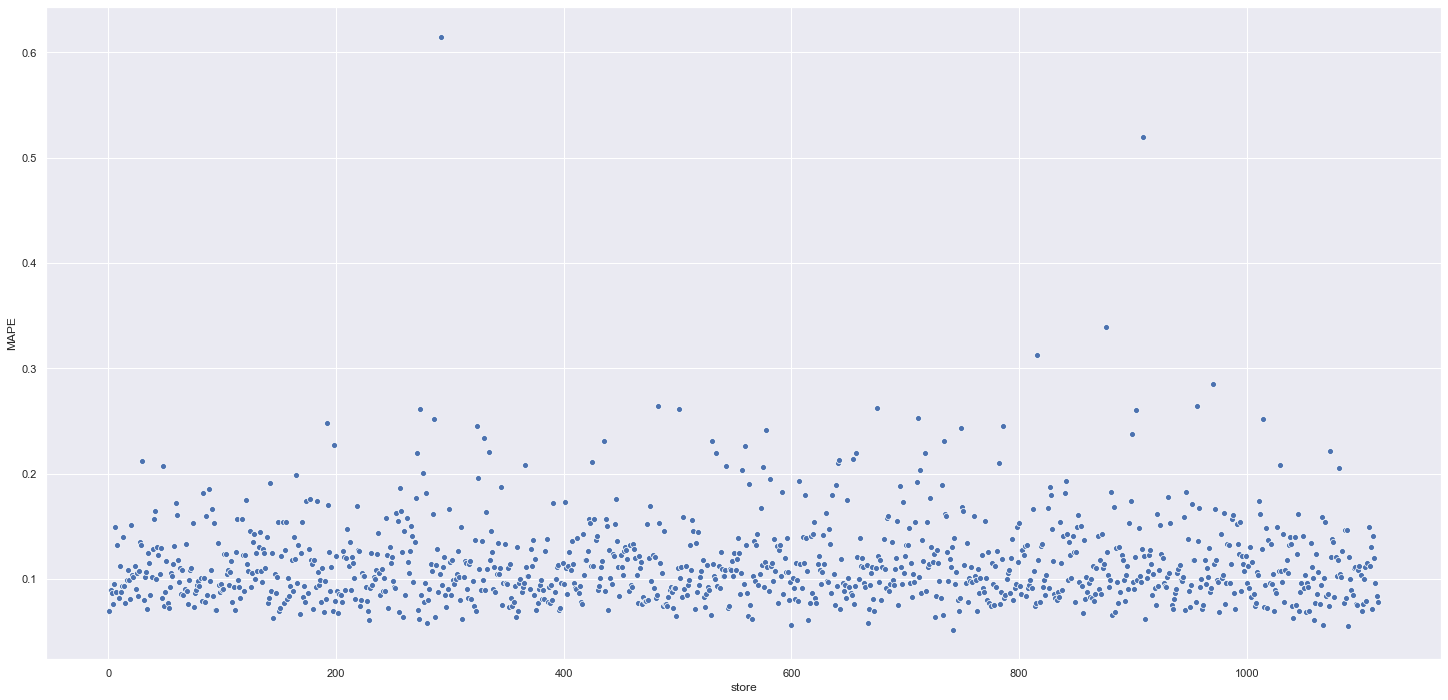

In [121]:
sns.scatterplot(x='store', y='MAPE', data=df9_2)

## 9.2 Total Performance

In [124]:
df9_3 = df9_2[['predictions', 'worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df9_3['Values'] =df9_3['Values'].map( 'R${:,.2f}'.format)

In [126]:
df9_3

,Scenario,Values
0,predictions,"R$286,046,123.11"
1,worst_scenario,"R$285,192,186.12"
2,best_scenario,"R$286,900,060.10"


## 9.3 Machine Learning Performance

In [128]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

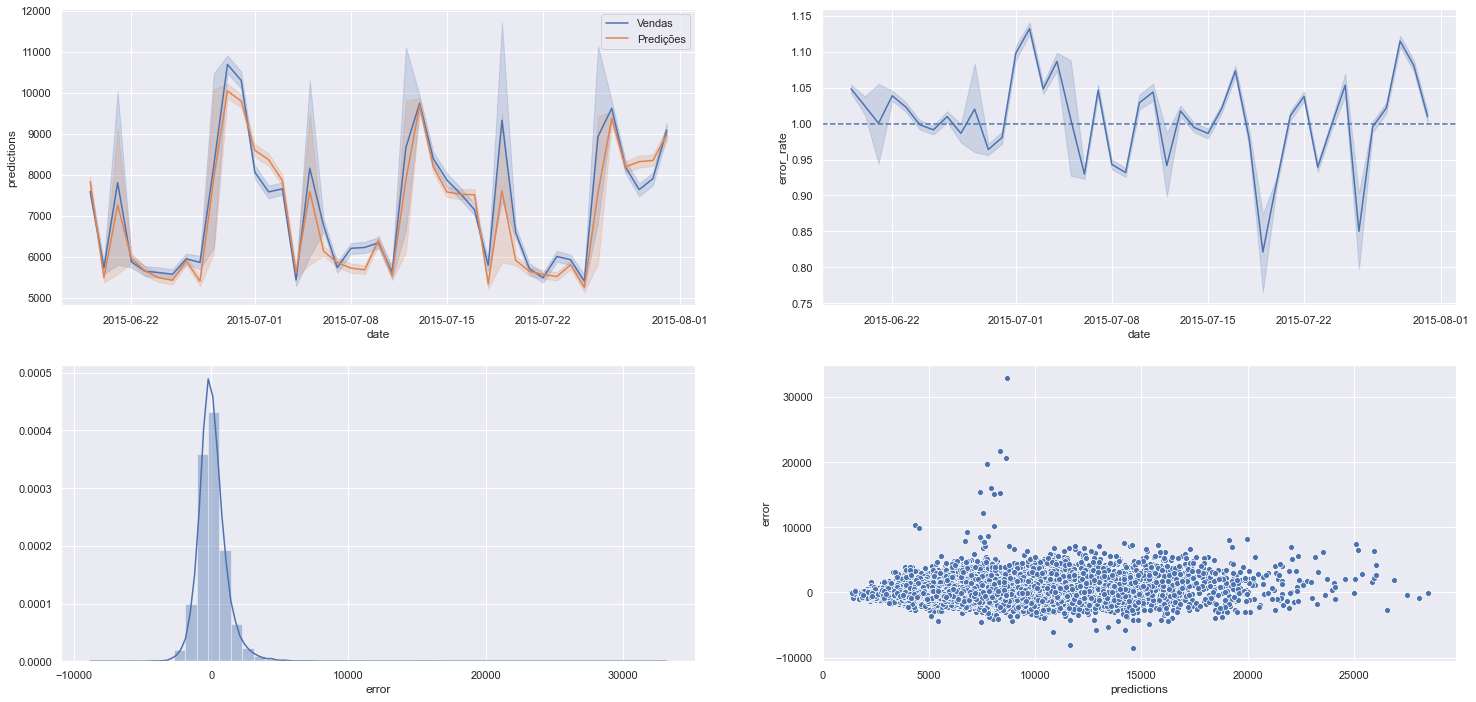

In [135]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='Vendas');
sns.lineplot(x='date', y='predictions', data=df9, label='Predições');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline( 1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df9);